In [ ]:
import random
import numpy as np
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from collections import deque

In [ ]:
# Tetris game class
class Tetris:

    '''Tetris game class'''

    # BOARD
    MAP_EMPTY = 0
    MAP_BLOCK = 1
    MAP_PLAYER = 2
    BOARD_WIDTH = 10
    BOARD_HEIGHT = 20

    TETROMINOS = {
        0: { # I
            0: [(0,0), (1,0), (2,0), (3,0)],
            90: [(1,0), (1,1), (1,2), (1,3)],
            180: [(3,0), (2,0), (1,0), (0,0)],
            270: [(1,3), (1,2), (1,1), (1,0)],
        },
        1: { # T
            0: [(1,0), (0,1), (1,1), (2,1)],
            90: [(0,1), (1,2), (1,1), (1,0)],
            180: [(1,2), (2,1), (1,1), (0,1)],
            270: [(2,1), (1,0), (1,1), (1,2)],
        },
        2: { # L
            0: [(1,0), (1,1), (1,2), (2,2)],
            90: [(0,1), (1,1), (2,1), (2,0)],
            180: [(1,2), (1,1), (1,0), (0,0)],
            270: [(2,1), (1,1), (0,1), (0,2)],
        },
        3: { # J
            0: [(1,0), (1,1), (1,2), (0,2)],
            90: [(0,1), (1,1), (2,1), (2,2)],
            180: [(1,2), (1,1), (1,0), (2,0)],
            270: [(2,1), (1,1), (0,1), (0,0)],
        },
        4: { # Z
            0: [(0,0), (1,0), (1,1), (2,1)],
            90: [(0,2), (0,1), (1,1), (1,0)],
            180: [(2,1), (1,1), (1,0), (0,0)],
            270: [(1,0), (1,1), (0,1), (0,2)],
        },
        5: { # S
            0: [(2,0), (1,0), (1,1), (0,1)],
            90: [(0,0), (0,1), (1,1), (1,2)],
            180: [(0,1), (1,1), (1,0), (2,0)],
            270: [(1,2), (1,1), (0,1), (0,0)],
        },
        6: { # O
            0: [(1,0), (2,0), (1,1), (2,1)],
            90: [(1,0), (2,0), (1,1), (2,1)],
            180: [(1,0), (2,0), (1,1), (2,1)],
            270: [(1,0), (2,0), (1,1), (2,1)],
        }
    }

    COLORS = {
        0: (255, 255, 255),
        1: (247, 64, 99),
        2: (0, 167, 247),
    }


    def __init__(self):
        self.reset()

    
    def reset(self):
        '''Resets the game, returning the current state'''
        self.board = [[0] * Tetris.BOARD_WIDTH for _ in range(Tetris.BOARD_HEIGHT)]
        self.game_over = False
        self.bag = list(range(len(Tetris.TETROMINOS)))
        random.shuffle(self.bag)
        self.next_piece = self.bag.pop()
        self._new_round()
        self.score = 0
        return np.array(self.board).reshape([20,10,1])


    def _get_rotated_piece(self):
        '''Returns the current piece, including rotation'''
        return Tetris.TETROMINOS[self.current_piece][self.current_rotation]


    def _get_complete_board(self):
        '''Returns the complete board, including the current piece'''
        piece = self._get_rotated_piece()
        piece = [np.add(x, self.current_pos) for x in piece]
        board = [x[:] for x in self.board]
        for x, y in piece:
            board[y][x] = Tetris.MAP_PLAYER
        return board


    def get_game_score(self):
        '''Returns the current game score.
        Each block placed counts as one.
        For lines cleared, it is used BOARD_WIDTH * lines_cleared ^ 2.
        '''
        return self.score
    

    def _new_round(self):
        '''Starts a new round (new piece)'''
        # Generate new bag with the pieces
        if len(self.bag) == 0:
            self.bag = list(range(len(Tetris.TETROMINOS)))
            random.shuffle(self.bag)
        
        self.current_piece = self.next_piece
        self.next_piece = self.bag.pop()
        self.current_pos = [3, 0]
        self.current_rotation = 0

        if self._check_collision(self._get_rotated_piece(), self.current_pos):
            self.game_over = True


    def _check_collision(self, piece, pos):
        '''Check if there is a collision between the current piece and the board'''
        for x, y in piece:
            x += pos[0]
            y += pos[1]
            if x < 0 or x >= Tetris.BOARD_WIDTH \
                    or y < 0 or y >= Tetris.BOARD_HEIGHT \
                    or self.board[y][x] == Tetris.MAP_BLOCK:
                return True
        return False


    def _rotate(self, angle):
        '''Change the current rotation'''
        r = self.current_rotation + angle

        if r == 360:
            r = 0
        if r < 0:
            r += 360
        elif r > 360:
            r -= 360

        self.current_rotation = r


    def _add_piece_to_board(self, piece, pos):
        '''Place a piece in the board, returning the resulting board'''        
        board = [x[:] for x in self.board]
        for x, y in piece:
            board[y + pos[1]][x + pos[0]] = Tetris.MAP_BLOCK
        return board


    def _clear_lines(self, board):
        '''Clears completed lines in a board'''
        # Check if lines can be cleared
        lines_to_clear = [index for index, row in enumerate(board) if sum(row) == Tetris.BOARD_WIDTH]
        if lines_to_clear:
            board = [row for index, row in enumerate(board) if index not in lines_to_clear]
            # Add new lines at the top
            for _ in lines_to_clear:
                board.insert(0, [0 for _ in range(Tetris.BOARD_WIDTH)])
        return len(lines_to_clear), board


    def get_next_states(self):
        '''Get all possible next states'''
        states = {}
        piece_id = self.current_piece
        
        if piece_id == 6: 
            rotations = [0]
        elif piece_id == 0:
            rotations = [0, 90]
        else:
            rotations = [0, 90, 180, 270]

        # For all rotations
        for rotation in rotations:
            piece = Tetris.TETROMINOS[piece_id][rotation]
            min_x = min([p[0] for p in piece])
            max_x = max([p[0] for p in piece])

            # For all positions
            for x in range(-min_x, Tetris.BOARD_WIDTH - max_x):
                pos = [x, 0]

                # Drop piece
                while not self._check_collision(piece, pos):
                    pos[1] += 1
                pos[1] -= 1

                # Valid move
                if pos[1] >= 0:
                    board = self._add_piece_to_board(piece, pos)
                    _, board = self._clear_lines(board)
                    states[(x, rotation)] = np.array(board).reshape([20,10,1])

        return states


    def play(self, x, rotation):
        '''Makes a play given a position and a rotation, returning the reward and if the game is over'''
        self.current_pos = [x, 0]
        self.current_rotation = rotation

        # Drop piece
        while not self._check_collision(self._get_rotated_piece(), self.current_pos):
            self.current_pos[1] += 1
        self.current_pos[1] -= 1

        # Update board and calculate score        
        self.board = self._add_piece_to_board(self._get_rotated_piece(), self.current_pos)
        lines_cleared, self.board = self._clear_lines(self.board)
        score = 1 + (lines_cleared ** 2) * Tetris.BOARD_WIDTH
        self.score += score

        # Start new round
        self._new_round()
        if self.game_over:
            score -= 2

        return score, self.game_over

In [ ]:
INPUT_SIZE = [20, 10, 1]
MEM_SIZE = 20000
DISCOUNT = 0.95
EPSILON = 1
EPSILON_MIN = 0
EPSILON_STOP_EPISODE = 1800
EPSILON_DECAY = (EPSILON - EPSILON_MIN) / EPSILON_STOP_EPISODE
env = Tetris()
episodes = 2000
max_steps = 2000
batch_size = 512
epochs = 2
log_every = 50
train_every = 1

In [ ]:
class DQNAgent:
    def __init__(self):
        self.memory = deque(maxlen=MEM_SIZE)
        self.model = self._build_model()
        self.epsilon = EPSILON

    def _build_model(self):
        '''Builds a Keras deep neural network model'''
        model = Sequential()

        model.add(Conv2D(64, (3, 3), input_shape=INPUT_SIZE))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(64, activation='relu'))

        model.add(Dense(1, activation='linear'))
        model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
        print(model.summary())
        return model


    def add_to_memory(self, current_state, next_state, reward, done):
        '''Adds a play to the replay memory buffer'''
        self.memory.append((current_state, next_state, reward, done))


    def random_value(self):
        '''Random score for a certain action'''
        return random.random()


    def predict_value(self, state):
        '''Predicts the score for a certain state'''
        state = np.reshape(state, [1] + INPUT_SIZE)
        return self.model.predict(state)[0]


    def best_state(self, next_states):
        '''Returns the best state for a given collection of states'''
        max_value = None
        best_action = None
        best_state = None

        if random.random() <= self.epsilon:
            return random.choice(list(next_states.items()))

        else:
            for action,state in next_states.items():

                value = self.predict_value(state)
                if not max_value or value > max_value:
                    max_value = value
                    best_action = action
                    best_state = state

        return best_action, best_state


    def train(self, batch_size=32, epochs=1):
        '''Trains the agent'''
        n = len(self.memory)
    
        if n >= batch_size:

            batch = random.sample(self.memory, batch_size)

            # Get the expected score for the next states, in batch (better performance)
            next_states = np.array([x[1] for x in batch])
            next_qs = [x[0] for x in self.model.predict(next_states)]

            x = []
            y = []

            # Build xy structure to fit the model in batch (better performance)
            for i, (state, _, reward, done) in enumerate(batch):
                if not done:
                    # Partial Q formula
                    new_q = reward + DISCOUNT * next_qs[i]
                else:
                    new_q = reward

                x.append(state)
                y.append(new_q)

            # Fit the model to the given values
            self.model.fit(np.array(x), np.array(y), batch_size=batch_size, epochs=epochs, verbose=0)

            # Update the exploration variable
            if self.epsilon > EPSILON_MIN:
                self.epsilon -= EPSILON_DECAY

agent = DQNAgent()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 18, 8, 64)         640       
_________________________________________________________________
activation_2 (Activation)    (None, 18, 8, 64)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 2, 128)         73856     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 2, 128)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)              

In [ ]:
from statistics import mean, median
from tqdm.notebook import tqdm

# Run dqn with Tetris
scores = []
for episode in tqdm(range(episodes//log_every)):
    progress = tqdm(range(log_every), desc="current score = ")
    for i in progress:
        current_state = env.reset()
        done = False
        steps = 0

        # Game
        while not done and (not max_steps or steps < max_steps):
            next_states = env.get_next_states()
            best_action, best_state = agent.best_state(next_states)
            reward, done = env.play(best_action[0], best_action[1])
            
            agent.add_to_memory(current_state, next_states[best_action], reward, done)
            current_state = next_states[best_action]
            steps += 1

        scores.append(env.get_game_score())
        progress.set_description(f"current score = {scores[-1]}")

        # Train
        if episode % train_every == 0:
            agent.train(batch_size=batch_size, epochs=epochs)

        # Logs
        if i==log_every-1:
            avg_score = mean(scores[-log_every:])
            min_score = min(scores[-log_every:])
            max_score = max(scores[-log_every:])
            print(avg_score, min_score, max_score)

19.94 10 38



20.26 12 35



21.46 11 33



22.2 13 61



23.24 9 46



22.18 15 38



22.6 13 40



22.58 12 33



24.38 12 50



23.86 11 39



26.08 14 45



23.7 12 41



25.52 15 43



27.1 16 45



29.56 14 68



28.08 15 49



27.8 14 62



30.32 19 54



30.26 16 80



32.66 17 65



36.552 19.199999999999996 66.00000000000004



41.49599999999998 22.399999999999995 76.99999999999997



49.12000000000001 27.200000000000006 115.19999999999995



50.43599999999998 27.000000000000007 82.79999999999995



61.36 36.0 106.0



63.75600000000002 30.799999999999994 112.20000000000005



72.52799999999999 31.199999999999992 237.60000000000008



78.728 46.80000000000001 142.99999999999994



86.23999999999997 50.399999999999984 184.8



91.86 48.0 177.0



91.58400000000003 54.40000000000001 166.40000000000003



123.01200000000003 47.59999999999999 506.5999999999997



118.51199999999996 46.80000000000001 226.79999999999993



135.356 56.999999999999986 300.20000000000005



186.32 76.0 988.0



215.292 54.600000000000016 730.8000000000005



215.86400000000003 96.80000000000003 664.3999999999997



266.70799999999997 105.79999999999995 777.4000000000003



337.43999999999994 100.79999999999997 1084.7999999999993



313.2 130.0 955.0




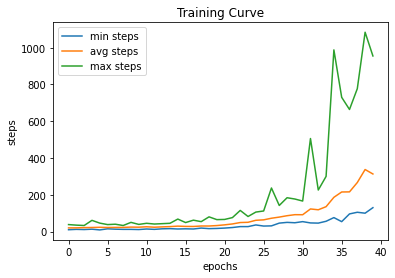

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([lo for avg,lo,hi in scores], label = "min steps")
plt.plot([avg for avg,lo,hi in scores], label = "avg steps")
plt.plot([hi for avg,lo,hi in scores], label = "max steps")
plt.xlabel('epochs')
plt.ylabel('steps')
plt.title('Training Curve')
plt.legend()
plt.show()

In [21]:
val_scores = []
for i in range(50):
    current_state = env.reset()
    done = False

    # Game
    while not done:
        next_states = env.get_next_states()
        best_action, best_state = agent.best_state(next_states)
        reward, done = env.play(best_action[0], best_action[1])
        current_state = next_states[best_action]

    val_scores.append(env.get_game_score())

print(mean(val_scores), min(val_scores), max(val_scores))

339.02 102 1078
